In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from scipy.signal import convolve
import scipy
from joblib import Parallel, delayed
import time
from scipy import sparse
import json
from tqdm import tqdm, tqdm_notebook
import os
from antigenicWaveSimulationMethods import main as coEvoSimulation
from formulas import compute_shift
from coverage import elementwise_coverage
from fitness import fitness_spacers, norm_fitness, virus_growth
from altImmunity import immunity_loss_uniform, immunity_gain_from_kernel
from initMethods import init_exptail, init_full_kernel, init_quarter_kernel, init_guassian, init_cond
from supMethods import time_conv, write2json, minmax_norm
from mutation import mutation
from randomHGT import get_time_next_HGT, HGT_logistic_event

In [15]:
params = { #parameters relevant for the equations
        "Nh":                     1E7,
        "N0":                     1E9, #This Will be updated by self-consitent solution
        "R0":                      20, 
        "M":                       10, #Also L, total number of spacers
        "mu":                     100, #mutation rate
        "gamma_shape":             20,
        "Np":                     100, #Number of Cas Protein
        "dc":                      10, #Required number of complexes to activate defence
        "h":                       10, #coordination coeff
        "r":                     2000, #cross-reactivity kernel
        "beta":                     0,
        "rate_HGT":                 0,
        "HGT_bonus_acq_ratio":      0,
        "rate_recovery":            0,
        "HGT_type":                 0,
    }
sim_params = { #parameters relevant for the simulation (including Inital Valuess)
        "continue":                 False, #DO NOT CREATE ARBITRARY FOLDERS ONLY FOR TESTS
        "xdomain":                  10000,
        "dx":                           1,
        "tf":                        4000,
        "dt":                           1,
        "dt_exact_fitness":             1,
        "dt_snapshot":                  1,
        "initial_mean_n":           [0,0],
        "initial_mean_nh":          [0,0],
        "conv_size":                 4000,
        "num_threads":                 8,
        "foldername":  "../Data_Single_Test_Det_Fit",
        "seed":                         34,
        "hard_N0":                      False,
    }

In [16]:
params, sim_params = init_cond(params, sim_params)
foldername = sim_params["foldername"]

try:
    write2json(foldername, params, sim_params)
except FileNotFoundError:
    os.mkdir(foldername)
    write2json(foldername, params, sim_params)


In [17]:
st1 = time.time()
n = init_guassian(params["N"], sim_params, "n")
nh = init_exptail(params["Nh"]*params["M"], params, sim_params, "nh")
kernel_conv = init_quarter_kernel(params, sim_params)
kernel_immunity = init_quarter_kernel(params, sim_params, type="Boltzmann")
ed = time.time()
            
nh_total = params["Nh"]
n_total = params["N"]
uc = params["uc"]
sigma = params["sigma"]
M0 = params["M0"]
t = 0

with open(foldername+'/runtime_stats.txt','w') as file:
    file.write(f't: {t}| init_functions: {time_conv(ed-st1)}| Phage Population: {n_total:.4f}| Spacer Population: {nh_total:.4f}| Uc: {uc:.4f}| sigma: {sigma:.4f}| M0: {M0:.4f} \n')


In [18]:
while(t < sim_params["tf"]):

    if t%sim_params["dt_snapshot"] == 0:
        sparse.save_npz(foldername+f"/sp_frame_n{t}",n.tocoo())
        sparse.save_npz(foldername+f"/sp_frame_nh{t}",nh.tocoo()) 

    if t%sim_params["dt_exact_fitness"] == 0:
        str1:float = time.time()
        p = elementwise_coverage(nh, n, kernel_conv, params, sim_params)
        sparse.save_npz(foldername+f"/sp_frame_p{t}",p.tocoo())
        st2 = time.time()
        f = fitness_spacers(n, nh, p, params, sim_params)
        sparse.save_npz(foldername+f"/sp_frame_f{t}", f.tocoo())
        f = norm_fitness(f, n, params, sim_params) #renormalize f

    else:
        st1 = time.time()
        raise NotImplementedError("dt_fast_fitness better be 1")

    n = virus_growth(n, f, params, sim_params, True) #update
            
    if (np.sum(n) <= 0) or (np.sum(n) >= (1/2)*np.sum(nh)):
        with open(foldername+'/runtime_stats.txt','a') as file:
            outstring = f"DEAD at: {t}| N: {np.sum(n)}| Coverage: {time_conv(st2-st1)}| Growth: {time_conv(st3-st2)}| Mutation: {time_conv(st4-st3)}| Immunity: {time_conv(ed-st4)}| Shift Amount: {np.linalg.norm(shift_vector)} \n"
            file.write(outstring)

    st3 = time.time()
    n = mutation(n, params, sim_params)

    st4 = time.time()
    nh_prev = nh

    params, sim_params, num_to_add, num_to_remove = HGT_logistic_event(t, n, params, sim_params)
    nh_gain = immunity_gain_from_kernel(nh, n, kernel_immunity, params, sim_params, num_to_add) #update nh
    nh = immunity_loss_uniform(nh_gain, n, params, sim_params, num_to_remove)
            
    diff_of_acquisition = num_to_add-num_to_remove
    shift_vector = compute_shift(nh, nh_prev, "max")
    ed = time.time()

    with open(foldername+'/runtime_stats.txt','a') as file:
        M = params["M"]
        outstring = f"t: {t}| N: {np.sum(n)}| Coverage: {time_conv(st2-st1)}| Growth: {time_conv(st3-st2)}| Mutation: {time_conv(st4-st3)}| Immunity: {time_conv(ed-st4)}| M: {M:.4f}| Net_Acq_Diff: {diff_of_acquisition:.4f}| Shift Amount: {np.linalg.norm(shift_vector):.4f} \n"
        file.write(outstring)

    t += sim_params["dt"]

/Users/zhizhang144515/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [54]:
num_to_remove

707

In [58]:
params["M"]*params["Nh"]

306318.99999999994

In [53]:
np.abs(np.sum(nh))

307040

In [25]:
foldername = "../Data/test13"
with open(foldername + "/params.json") as json_file:
    params = json.load(json_file)
with open(foldername + "/sim_params.json") as json_file:
    sim_params = json.load(json_file)

i = 999
kernel_quarter = init_quarter_kernel(params, sim_params)

n = sparse.load_npz(foldername+f"/sp_frame_n{i}.npz").todok()
nh = sparse.load_npz(foldername+f"/sp_frame_nh{i}.npz").todok()

In [26]:
p = elementwise_coverage(nh, n, kernel_quarter, params, sim_params)
f = fitness_spacers(n, nh, p, params, sim_params) #f is now a masked array (where mask is where eff_R0 = 0)
f = norm_fitness(f, n, params, sim_params)

elementwise_coverage took 00:00:37


In [33]:
a = np.nonzero(f_squash)

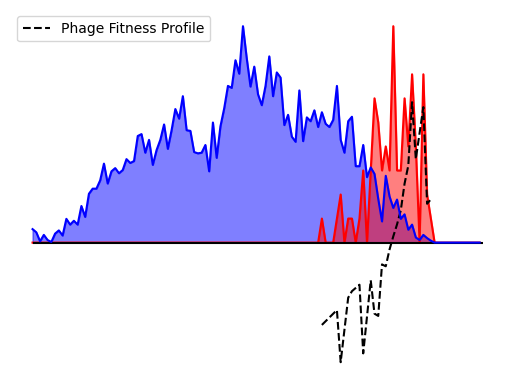

In [46]:
from supMethods import read_json


plt.figure()
foldername = "../Data_Mutation_Large/mu_1_seed0"
params, sim_params = read_json(foldername)

i = 999
n = sparse.load_npz(foldername+f"/sp_frame_n{i}.npz")
n_squash = np.flip(np.sum(n.toarray(), axis = 0)[9080:9200])
nonzero_ind = np.nonzero(n_squash)[0]

plt.plot(minmax_norm(n_squash), color = 'red')

f = sparse.load_npz(foldername+f"/sp_frame_f{i}.npz").todok()
f = norm_fitness(f, n, params, sim_params)
f_squash = np.flip(np.sum(f.toarray(), axis = 0)[9080:9200])
nonzero_ind = np.nonzero(f_squash)[0]

plt.plot(nonzero_ind, f_squash[nonzero_ind], color = 'black', linestyle = '--', label = 'Phage Fitness Profile')

nh = sparse.load_npz(foldername+f"/sp_frame_nh{i}.npz").todok()
nh_squash = np.flip(np.sum(nh.toarray(), axis = 0)[9080:9200])

plt.hlines(0, 0, 120, color = "black")

plt.plot(minmax_norm(nh_squash), color = 'blue')
x_range = range(len(nh_squash))
plt.fill_between(x_range, minmax_norm(nh_squash),color = 'blue', alpha = 0.5)
plt.fill_between(x_range, minmax_norm(n_squash),color = 'red', alpha = 0.5)

plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.axis('off')
plt.legend()

In [ ]:
R0_sweep = [20]
kernel = init_quarter_kernel(params, sim_params)
foldername = "test0/"
write2json(foldername, params, sim_params)

for R0 in R0_sweep:
    params["R0"] = R0
    n = init_guassian(params["N"], sim_params, "n")
    nh = init_guassian(params["Nh"], sim_params, "nh")

    for i in range(10000):

        if (i%100 == 0 or i < 20):
            sparse.save_npz(foldername+f"/sp_frame_n{i}",n.tocoo())
            sparse.save_npz(foldername+f"/sp_frame_nh{i}",nh.tocoo())

        p = elementwise_coverage(nh, n, kernel, params, sim_params)
        f = fitness_spacers(n, nh, p, params, sim_params) #f is now a masked array (where mask is where eff_R0 = 0)
        # f = norm_fitness(f, n, params, sim_params)
        n = virus_growth(n, f, params, sim_params) #update

        n = mutation(n, params, sim_params)
        nh = immunity_update(nh, n, params, sim_params) #update nh

        if np.sum(n) >= 10*params["Nh"]:
            break